# Eigen-value problem for Np fermions
### In this code we are going to 
### 1-Construct Hamiltonian  operator for Np fermions in a 1D system
### 2-Construct Permutation operator 
### 3-Diagonalize Hamiltonian operator
### 4-Calculate Correlation function

Initialization :

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [2]:
Np = 3 # number of particles
L = 8 # length of system
V1 = 1 # interaction strength (coupling constant)
Id = sp.sparse.csr_matrix(np.eye(L)) # single particle identity operator
bc = 1 # boundary condition
T = np.diag(np.ones(L-1),1) + bc*np.diag([1],-(L-1))
T = sp.sparse.csr_matrix(T)

Define particle kinetic energy operator of j'th particle as $h_{1p}^{(j)}$ = $-\frac{h^2}{2m}\frac{(T+T'-2I)}{\epsilon^2}$ with $\frac{h^2}{2m}\frac{1}{\epsilon^2} = 1$ and removed $2I$ part : 

In [3]:
h_1p = -(T.T+T)

Define 1-particle density operator : 

In [4]:
empty = sp.sparse.csr_matrix((L,L))
n_1p = [None] * L
for i1 in range(0,L):
    n_1p[i1] = empty.copy()
    n_1p[i1][i1,i1] = 1

F:\Anaconda\lib\site-packages\scipy\sparse\_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


2 fermion problem :

In [5]:
H = sp.sparse.kron(h_1p,Id) + sp.sparse.kron(Id,h_1p)
for i1 in range(0,L) :
    i1_p = np.mod(i1+1,L)
    i1_m = np.mod(i1-1,L)
    H = H + V1*sp.sparse.kron(n_1p[i1],n_1p[i1_p]+n_1p[i1_m])

Define permutation operator : 

In [6]:
index_12 = np.reshape(np.arange(1,L**2+1,1),(L,L))
index_21 = np.ravel(np.reshape(index_12.T,(-1,1)))
A = np.eye(L**2)
P12 = A[:,index_21-1] 

Diagonalization and imposing fermionic statistics

In [7]:
HP=H+(10**4)*P12
HP = (HP+HP.T)/2 # ensuring HP is hermitian
nE = int(min(sp.special.comb(L,2),np.size(HP,0))) #number of desired eigenvalues
eigenvalues, eigenvectors = sp.sparse.linalg.eigs(HP, k=nE, which='SR', tol=1e-16)
eigenvalues = eigenvalues.real
S = np.argsort(eigenvalues)
eigenvalues = np.sort(eigenvalues)
eigenvectors = sp.sparse.csr_matrix(eigenvectors[:,S])
E = np.diag((eigenvectors.conjugate().T*H*eigenvectors).todense()).real
E_2particle = E[0:min(10,len(E))]
dE_2particle = E_2particle[1:]-E_2particle[0]

In [8]:
E_2particle

array([-3.35872893, -3.35872893, -2.62619807, -1.8136065 , -1.8136065 ,
       -1.37321758, -1.37321758, -1.04597605, -1.04597605, -0.29399246])

In [9]:
dE_2particle

array([2.22044605e-15, 7.32530858e-01, 1.54512242e+00, 1.54512242e+00,
       1.98551135e+00, 1.98551135e+00, 2.31275287e+00, 2.31275287e+00,
       3.06473647e+00])

Plot result

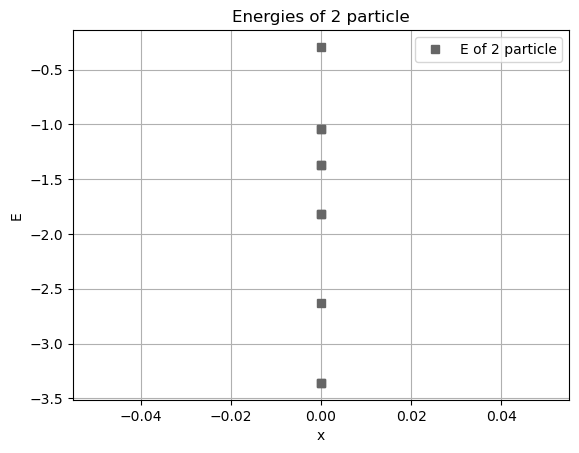

In [10]:
plt.plot(np.zeros(len(E_2particle)), E_2particle,'s' ,color='0.4' ,label='E of 2 particle')
plt.title('Energies of 2 particle')
plt.xlabel('x')
plt.ylabel('E')
plt.legend()
plt.grid(True)
plt.show()

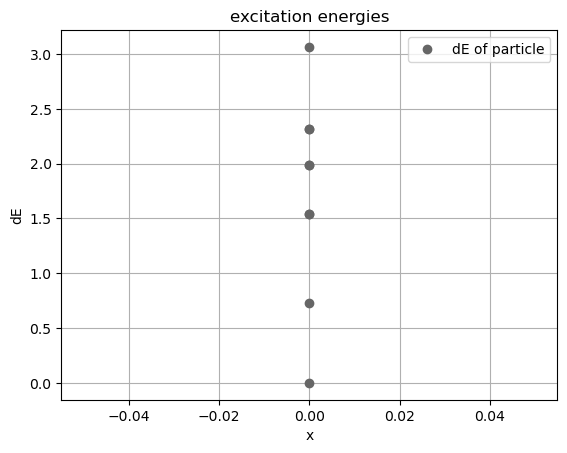

In [11]:
plt.plot(np.zeros(len(dE_2particle)), dE_2particle,'o',color='0.4' ,label='dE of particle')
plt.title('excitation energies')
plt.xlabel('x')
plt.ylabel('dE')
plt.legend()
plt.grid(True)
plt.show()

### General problem : NP > 2 particles

In [12]:
H = h_1p
_Id_ = Id 
Id_prev = 1
N_tot = [None] * L
for i1 in range(0,L):
    N_tot[i1] = n_1p[i1]
perm = [None] * Np

In [13]:
for nop in range(2,Np+1):
    H = sp.sparse.kron(H,Id)+sp.sparse.kron(_Id_,h_1p)
    for i1 in range(0,L):
        i1_p = np.mod(i1+1,L)
        i1_m = np.mod(i1-1,L)
        H = H + V1*sp.sparse.kron(N_tot[i1],n_1p[i1_p]+n_1p[i1_m])
    for i1 in range(0,L):
        N_tot[i1] = sp.sparse.kron(N_tot[i1],Id) + sp.sparse.kron(_Id_,n_1p[i1])
    perm[nop-1] = sp.sparse.kron(Id_prev,P12)
    for ip in range(1,nop-1):
        perm[ip] = sp.sparse.kron(perm[ip],Id)
    Id_prev = _Id_
    _Id_ = sp.sparse.kron(_Id_,Id)
    # permutation operator
    mLambda = 1e4
    P_tot = sp.sparse.csr_matrix(np.shape(perm[nop-1]))
    for ip in range(1,nop):
        P_tot = P_tot + perm[ip]  
    # diagonalization and imposing fermionic statistics
    HP = H + mLambda*P_tot
    HP = (HP+HP.conjugate().T)/2
    nE = int(min(sp.special.comb(L,nop),np.size(HP,0)))
    eigenvalues, eigenvectors = sp.sparse.linalg.eigs(HP, k=nE, which='SR', tol=1e-16)
    eigenvalues = eigenvalues.real
    S = np.argsort(eigenvalues)
    eigenvalues = np.sort(eigenvalues)
    eigenvectors = sp.sparse.csr_matrix(eigenvectors[:,S])
    E_Np_particle = np.diag((eigenvectors.conjugate().T*H*eigenvectors).todense()).real

Result : 

In [14]:
E_Np_particle = E_Np_particle[0:min(10,len(E_Np_particle))]
dE_Np_particle = E_Np_particle[1:]-E_Np_particle[0]

In [15]:
E_Np_particle

array([-4.49395921, -3.10505786, -3.10505786, -2.76252736, -2.76252736,
       -2.18327636, -2.18327636, -1.71934215, -1.10991626, -1.09634536])

In [16]:
dE_Np_particle

array([1.38890135, 1.38890135, 1.73143185, 1.73143185, 2.31068285,
       2.31068285, 2.77461705, 3.38404294, 3.39761385])

Plot Result :

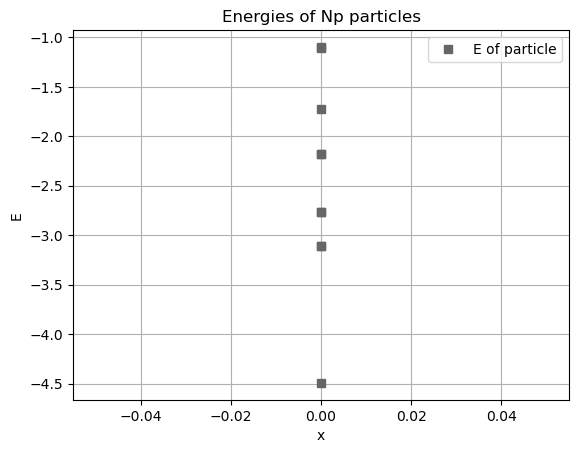

In [17]:
plt.plot(np.zeros(len(E_Np_particle)), E_Np_particle,'s' ,color='0.4' ,label='E of particle')
plt.title('Energies of Np particles')
plt.xlabel('x')
plt.ylabel('E')
plt.legend()
plt.grid(True)
plt.show()

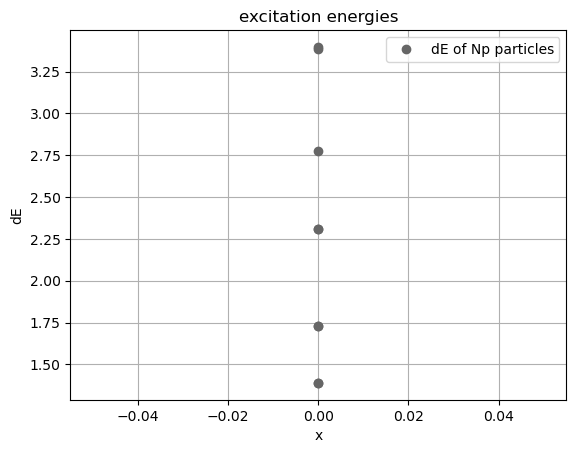

In [18]:
plt.plot(np.zeros(len(dE_Np_particle)), dE_Np_particle,'o',color='0.4' ,label='dE of Np particles')
plt.title('excitation energies')
plt.xlabel('x')
plt.ylabel('dE')
plt.legend()
plt.grid(True)
plt.show()

# Correlation function

### Based on what we discussed in the last section :

correlation function  $$ = \frac{1}{\begin{pmatrix} L \\ 2 \end{pmatrix}} \Sigma_{p<p'} <\psi|n_{i}^{p}n_{j}^{p'}|\psi>  $$
average number in i-th point  $$ = \Sigma_{p=1}^{N_p} <\psi|n_i^p|\psi>$$
We also have learned that in a non-interaction , periodic system the correlation is :
$$
C = (\frac{N_p}{L^d})^2
$$
So in our system when $N_p = 3 , L = 10 , d=1$ we know $C_n = 0.09$. We can compare the correlation number with $C_n$ and say if its attraction force or repulsion.

Solution 1 : 

In [19]:
def correlation_function(p,i,j,eigenvectors,state_number,N_tot,pn):
    psi = eigenvectors[:,state_number]
    temp = 0
    for p_prime in range(p+1,pn+1):
        temp = temp + psi.conjugate().T*N_tot[i]*N_tot[j]*psi
    ans = temp.todense()[0,0]/sp.special.comb(L,2)
    return ans
def average_number(i,eigenvectors,state_number,N_tot,particles_number):
    psi = eigenvectors[:,state_number]
    temp = 0
    for p in range(particles_number):
        temp = temp + psi.conjugate().T*N_tot[i]*psi
    ans = temp.todense()[0,0] 
    return ans

calculate correlation function and average numbers : 

In [20]:
state_number = 0
distance = np.arange(0,L,1)
points = np.arange(1,L,1)
correlations = np.zeros(L)
averages = np.zeros(L-1)
# correlation function for p = 1 and i = 0 and j = 1 to 9
for d in distance:
    correlations[d] = correlation_function(1,0,d,eigenvectors,state_number,N_tot,Np)
for i in points:
    averages[i-1] = average_number(i-1,eigenvectors,state_number,N_tot,Np)

C:\Users\Amir\AppData\Local\Temp\ipykernel_9660\3697820487.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  correlations[d] = correlation_function(1,0,d,eigenvectors,state_number,N_tot,Np)
C:\Users\Amir\AppData\Local\Temp\ipykernel_9660\3697820487.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  averages[i-1] = average_number(i-1,eigenvectors,state_number,N_tot,Np)


plot result : 

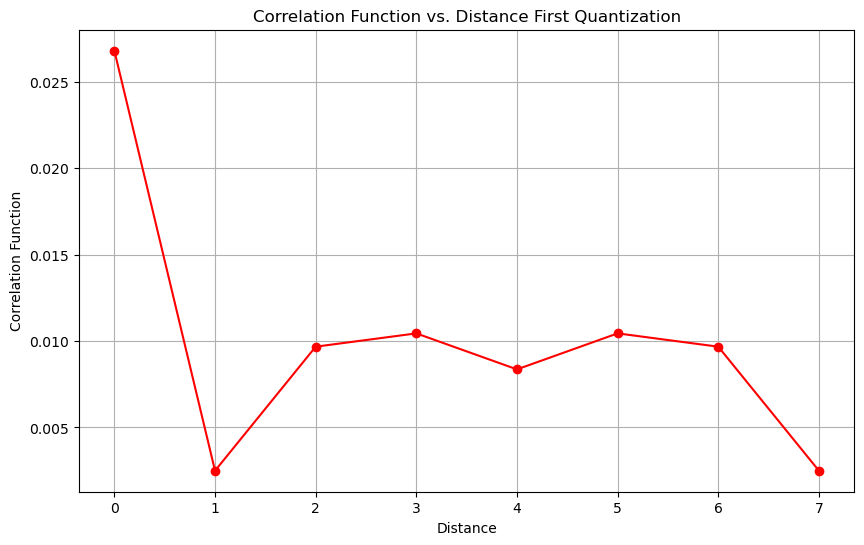

In [21]:
x = np.linspace(1, 9, num=9, endpoint=True)
y = correlations
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,L,1), correlations, 'ro-')
plt.xlabel('Distance')
plt.ylabel('Correlation Function')
plt.title('Correlation Function vs. Distance First Quantization')
plt.grid(True)
plt.show()

solution 2 : 
C = $<\psi| N_{tot}(i)N_{tot}(j)|\psi> - <\psi|N_{tot}(i)|\psi><\psi|N_{tot}(j)|\psi>$